In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

     |████████████████████████████████| 160 kB 11.2 MB/s 


In [2]:
C1, C2, C3, C4, C5 = 0.74, 2.01, 0.74, 0.74, 2.09
W1, W2, W3, W4 = 3, 0, 0, 3
cw, Cvap, Lv, CL = 4.19, 1.83, 2256, 0.27

cha_res = [ 
  [1450000, 17000, 31100, 369, 314, 366000, 467000, 177, 22, 509, 314, 31.1],
  [19600, 36.7, 650, 7.59, 9.28, 4450, 17800, 2.74, 14.1, 7.07, 9.28, 0.29],
  [9270, 17.9, 150, 3.11, 1.6, 249, 19500, 1.07, 6.67, 3.21, 1.6, 0.0513],
  [2790000, 22200, 104000, 1340, 873, 508000, 4400000, 442, 118, 1110, 873, 95.3],
  [1.47E-11, 0, 9.69E-13, 5.09E-15, 8.25E-15, 0, 2.02E-11, 5.15E-15, 1.38E-14, 8.44E-15, 8.25E-15, 9.38E-17],
  [17800, 10.7, 226, 3.4, 2.94, 1750, 6400, 2.02, 12.5, 6.04, 2.94, 0.131],
  [526, 2.35, 11.2, 0.131, 0.121, 93, 403, 0.0721, 0.384, 0.191, 0.121, 0.00923],
  [20300000, 8270, 800000, 7130, 8760, 1360000, 25300000, 3180, 14400, 7470, 8760, 0.131],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [42300, 42.9, 148, 2.27, 2.66, 7050, 925, 4.32, 30, 14.1, 2.66, 0.167],
  [3.19, 9.19E-07, 0.00474, 0.00015, 0.000161, 0.000151, 0.0498, 0.000324, 0.00226, 0.00106, 0.000161, 125000],
  [15300, 485, 261, 8.18, 3.62, 4010, 10100, 2.4, 11.7, 5.97, 3.62, 0.196],
  [3470, 0, 1460, 5.83, 111, 0, 41700, 0, 0, 0, 111, 0.0398],
]
BEESweights = [5, 11, 5, 16, 16, 5.5, 6, 5.5, 11, 5, 5, 6, 3]

user_Asphalt, Additive, user_mix_tem, to = 4.4, 0.3, 120, 25
dNAs, dCR, dRAP, dRCA, dAB, dCA = 73, 73*2, 73*2, 73*2, 592, 248
PCOST_NAs, PCOST_CR, PCOST_RAP, PCOST_RCA, PCOST_AB, PCOST_CA = 9.4, 9.4*2, 9.4*2, 9.4*2, 115, 150
TCOST_NAs, TCOST_CR, TCOST_RAP, TCOST_RCA, TCOST_AB, TCOST_CA = 0.31, 0.31, 0.31, 0.31, 0.31, 0.31
LHV, HFOPRICE = 42.18, 1.18

In [3]:
asphalt_mass = 1*user_Asphalt/100
additive_mass = asphalt_mass*Additive/100
asphalt_mass = asphalt_mass + additive_mass
NAs_mass = 1 - asphalt_mass
TE = (((user_mix_tem-to)*(NAs_mass*C1 + asphalt_mass*C5)) + ((100-to)*(NAs_mass*W1*cw)) + ((user_mix_tem-100)*(NAs_mass*W1*Cvap)) + (Lv*NAs_mass*W1)) * (1+CL)

max_env_imp = 0
vector_max_env_imp = np.zeros(13, dtype=float)
for i in range(0, 13):
  FSC = (cha_res[i][0]+cha_res[i][1])*NAs_mass + cha_res[i][5]*asphalt_mass + cha_res[i][6]*additive_mass
  SSC = cha_res[i][7]*NAs_mass*dNAs + cha_res[i][8]*asphalt_mass*dAB + cha_res[i][9]*additive_mass*dCA
  TSC = cha_res[i][10]*NAs_mass + cha_res[i][11]*TE
  vector_max_env_imp[i] = FSC + (2*SSC) + TSC
  max_env_imp = max_env_imp + (vector_max_env_imp[i]*BEESweights[i]/100)
max_env_imp = max_env_imp/1000000 #results_in_MegaPoints

PC_term1 = NAs_mass*PCOST_NAs + asphalt_mass*PCOST_AB + additive_mass*PCOST_CA
PC_term2 = NAs_mass*dNAs*TCOST_NAs + asphalt_mass*dAB*TCOST_AB + additive_mass*dCA*TCOST_CA
PC_term3 = TE/LHV*HFOPRICE
max_production_cost = PC_term1 + PC_term2 + PC_term3

In [4]:
penalize = 10000
vector_CR, vector_RAP, vector_RCA, vector_EI, vector_PC = [], [], [], [], []
def funcion_objetivo(individual):
  CR, RAP, RCA = individual[0], individual[1], individual[2]
  if CR<0 or CR>6 or RAP<0 or RAP>30 or RCA<0 or RCA>45: 
    return penalize, penalize

  if CR > 0:
    mix_tem = user_mix_tem + 10
  else:
    mix_tem = user_mix_tem
  asphalt_rap_correction = 63.854 - math.sqrt(4043.467+(26.738*RAP))
  asphalt_rca_correction = 20.958 - math.sqrt(464.284-(10.225*RCA))
  asphalt_correction = asphalt_rap_correction + asphalt_rca_correction
  Asphalt = user_Asphalt*(1+asphalt_correction/100)
  
  asphalt_mass = 1*Asphalt/100
  additive_mass = asphalt_mass*Additive/100
  asphalt_mass = asphalt_mass + additive_mass
  aggregate_mass = 1 - asphalt_mass
  CR_mass = aggregate_mass*(0.5*CR/100)
  RAP_mass = aggregate_mass*RAP/100
  RCA_mass = aggregate_mass*(0.5*RCA/100)
  NAs_mass = aggregate_mass - CR_mass - RAP_mass - RCA_mass

  a = (mix_tem-to)*(NAs_mass*C1 + CR_mass*C2 + RAP_mass*C3 + RCA_mass*C4 + asphalt_mass*C5)
  b = cw*(100-to)*(NAs_mass*W1 + CR_mass*W2 + RAP_mass*W3 + RCA_mass*W4)
  c = Cvap*(mix_tem-100)*(NAs_mass*W1 + CR_mass*W2 + RAP_mass*W3 + RCA_mass*W4)
  d = Lv * (NAs_mass*W1 + CR_mass*W2 + RAP_mass*W3 + RCA_mass*W4) 
  TE = (a+b+c+d)*(1+CL)

  env_imp = 0
  vector_env_imp = np.zeros(13, dtype=float)
  for i in range(0, 13):
    FSC = (cha_res[i][0]+cha_res[i][1])*NAs_mass + cha_res[i][2]*CR_mass + cha_res[i][3]*RAP_mass + cha_res[i][4]*RCA_mass + cha_res[i][5]*asphalt_mass + cha_res[i][6]*additive_mass
    SSC = (cha_res[i][7]*(NAs_mass*dNAs+CR_mass*dCR+RAP_mass*dRAP+RCA_mass*dRCA)) + cha_res[i][8]*asphalt_mass*dAB + cha_res[i][9]*additive_mass*dCA
    TSC = cha_res[i][10]*NAs_mass + cha_res[i][11]*TE
    vector_env_imp[i] = FSC + (2*SSC) + TSC
    env_imp = env_imp + (vector_env_imp[i]*BEESweights[i]/100)
  env_imp = env_imp/1000000 #results_in_MegaPoints

  PC_term1 = NAs_mass*PCOST_NAs + CR_mass*PCOST_CR + RAP_mass*PCOST_RAP + RCA_mass*PCOST_RCA + asphalt_mass*PCOST_AB + additive_mass*PCOST_CA
  PC_term2 = NAs_mass*dNAs*TCOST_NAs + CR_mass*dCR*TCOST_CR + RAP_mass*dRAP*TCOST_RAP + RCA_mass*dRCA*TCOST_RCA + asphalt_mass*dAB*TCOST_AB + additive_mass*dCA*TCOST_CA
  PC_term3 = TE/LHV*HFOPRICE
  production_cost = PC_term1 + PC_term2 + PC_term3

  if env_imp>max_env_imp or production_cost>max_production_cost:
    return penalize, penalize

  vector_CR.append(CR)
  vector_RAP.append(RAP)
  vector_RCA.append(RCA)
  vector_EI.append(env_imp)
  vector_PC.append(production_cost)
  return env_imp, production_cost

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


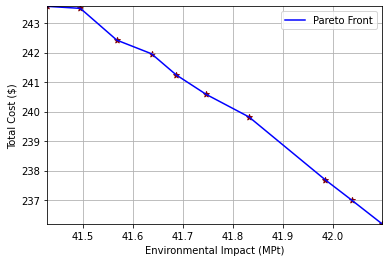

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_CR", random.uniform, 1, 6.01)
toolbox.register("attr_RAP", random.uniform, 1, 30.01)
toolbox.register("attr_RCA", random.uniform, 1, 45.01)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_CR, toolbox.attr_RAP, toolbox.attr_RCA), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, 400)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=45, indpb=0.1)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", funcion_objetivo)

def main():
  pop = toolbox.population()
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)
  logbook = tools.Logbook()  
  pareto = tools.ParetoFront() 
  pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.2, ngen=80, stats=stats, halloffame=pareto, verbose=False)
  return pop, logbook, pareto

if __name__ == "__main__":    
    pop, log, pareto = main()
    res_individuos = open("final_individuals.txt", "w")
    res_fitness = open("fitness.txt", "w")
    for ind in pareto:
        res_individuos.write(str(ind))
        res_individuos.write("\n")
        res_fitness.write(str(ind.fitness.values[0]))
        res_fitness.write(",")
        res_fitness.write(str(ind.fitness.values[1]))
        res_fitness.write("\n")
    res_fitness.close()
    res_individuos.close()

def plot_frente():
  datos_pareto = np.loadtxt("fitness.txt", delimiter=",")
  plt.scatter(datos_pareto[: ,0], datos_pareto[: ,1], marker="*", color="maroon")
  plt.plot(datos_pareto[: ,0], datos_pareto[: ,1], color="blue")
  plt.xlabel("Environmental Impact (MPt)")
  plt.ylabel("Total Cost ($)")
  plt.grid(True)
  plt.xlim([np.amin(datos_pareto[: ,0]), np.amax(datos_pareto[: ,0])])
  plt.ylim([np.amin(datos_pareto[: ,1]), np.amax(datos_pareto[: ,1])])
  plt.legend(["Pareto Front"], loc="upper right")
  plt.savefig("Pareto_conjunto.eps", dpi = 500)
plot_frente()